<a href="https://colab.research.google.com/github/Sobiii/Neural-Networks-CIFAR-10-Assignment/blob/main/Neural_Networks_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Reading CIFAR-10 and creating dataloaders (5%)



In [1]:
# Setting up google drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


The CIFAR-10 python dataset has been downloaded from the University of Toronto website.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Define the transform functions for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Loading the CIFAR-10 dataset

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Creating dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2) # training dataloader object
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2) # testing dataloader object

# Defining the class labels

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Accessing labels from dataloaders

for images, labels in trainloader:
    print(images.shape)  # shape of images batch 
    print(labels.shape)  # shape of labels batch 
    break  


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])


# 2) Creating the model (40%)

In [2]:
# Creating the Model 

class MyModel(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, num_conv_layers, num_classes, hidden_layers, hidden_units):
        super(MyModel, self).__init__()
        self.mlp_layer = nn.Linear(in_channels, out_channels)  # MLP layer to compute 'a'
        self.conv_layers = nn.ModuleList()
        for _ in range(num_blocks):
            for _ in range(num_conv_layers):
                conv_layer = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
                self.conv_layers.append(conv_layer)
            in_channels = out_channels  # Updating the number of input channels 
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # SpatialAveragePooling

        # The MLP Classifier

        self.classifier = nn.Sequential()
        if hidden_layers > 0:
            self.classifier.add_module('hidden_layer_0', nn.Linear(out_channels, hidden_units))
            self.classifier.add_module('relu_0', nn.ReLU(inplace=True))
            for i in range(1, hidden_layers):
                self.classifier.add_module(f'hidden_layer_{i}', nn.Linear(hidden_units, hidden_units))
                self.classifier.add_module(f'relu_{i}', nn.ReLU(inplace=True))
            self.classifier.add_module('output_layer', nn.Linear(hidden_units, num_classes))
        else:
            self.classifier.add_module('output_layer', nn.Linear(out_channels, num_classes))

    def forward(self, x):
        a = self.mlp_layer(self.avg_pool(x).squeeze())  # Prediciting 'a' using the MLP layer
        a_list = []
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            a_list.append(x)
        O = torch.sum(torch.stack(a_list, dim=1), dim=1)  # Combine outputs using sum along the stack dimension
        f = self.avg_pool(O).squeeze()  # Calculating 'f' using SpatialAveragePooling
        output = self.classifier(f)  # Passing 'f' to the MLP classifier
        return output, a_list


### Initialising the model

[Note to self - these hyperparameter settings are important for fine tuning the model]

In [3]:
# Initialising the model
# Example model parameters:

in_channels = 3  # Number of input channels (3 for RGB images)
out_channels = 3  # Number of output channels (3 for RGB images) 
num_blocks = 3  # Number of blocks in the backbone [Can be fined tuned for model performance]
num_conv_layers = 2  # Number of convolutional layers per block (K) [Can be fined tuned for model performance]
num_classes = 10  # Number of output classes for classification
hidden_layers = 4  # Number of hidden layers in the MLP classifier [Can be fined tuned for model performance]
hidden_units = 256  # Number of hidden units in each hidden layer of the MLP classifier [Can be fined tuned for model performance]

# Printing the models architecture

model = MyModel(in_channels, out_channels, num_blocks, num_conv_layers, num_classes, hidden_layers, hidden_units)
print(model)

MyModel(
  (mlp_layer): Linear(in_features=3, out_features=3, bias=True)
  (conv_layers): ModuleList(
    (0-5): 6 x Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (hidden_layer_0): Linear(in_features=3, out_features=256, bias=True)
    (relu_0): ReLU(inplace=True)
    (hidden_layer_1): Linear(in_features=256, out_features=256, bias=True)
    (relu_1): ReLU(inplace=True)
    (hidden_layer_2): Linear(in_features=256, out_features=256, bias=True)
    (relu_2): ReLU(inplace=True)
    (hidden_layer_3): Linear(in_features=256, out_features=256, bias=True)
    (relu_3): ReLU(inplace=True)
    (output_layer): Linear(in_features=256, out_features=10, bias=True)
  )
)


#3) Creating the loss and optimiser (5%)

I will be calculating loss using the Cross-Entropy Loss method. Cross-entropy loss is commonly used for classification problems, where the goal is to classify inputs into discrete categories. It measures the dissimilarity between the predicted class probabilities and the ground truth labels. [Need to reword]

In [4]:
# Creating cross-entropy loss

loss = nn.CrossEntropyLoss()

# Defining an optimizer

lr = 0.1  # Learning rate
wd = 0  # Weight decay (regularization)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)  # SGD optimizer with given learning rate and weight decay

#4) Training script (30%)

In [47]:
def train(model, trainloader, loss, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for batch_idx, (X, y) in enumerate(trainloader):
            optimizer.zero_grad()  # Zero the gradients of the model parameters
            outputs, _ = model(X)  # Forward pass to obtain model predictions
            l = loss(outputs, y)  # Compute the loss between predictions and ground truth labels
            l.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model parameters using the optimizer

            # Print the progress of training
            if batch_idx % 100 == 0:
                print('Epoch [{}/{}]\tBatch [{}/{}]\tLoss: {:.4f}'.format(
                    epoch + 1, epochs, batch_idx + 1, len(trainloader), l.item()))

    print('Training finished.')

In [49]:
# Write code for training the model here. This refers to calling the train function.

train(model, trainloader, loss, optimizer, 3)

Epoch [1/3]	Batch [1/782]	Loss: 2.0483
Epoch [1/3]	Batch [101/782]	Loss: 1.9730
Epoch [1/3]	Batch [201/782]	Loss: 2.2789
Epoch [1/3]	Batch [301/782]	Loss: 1.9228
Epoch [1/3]	Batch [401/782]	Loss: 2.0613
Epoch [1/3]	Batch [501/782]	Loss: 1.9579
Epoch [1/3]	Batch [601/782]	Loss: 2.0597
Epoch [1/3]	Batch [701/782]	Loss: 2.1713
Epoch [2/3]	Batch [1/782]	Loss: 2.0940
Epoch [2/3]	Batch [101/782]	Loss: 2.0389
Epoch [2/3]	Batch [201/782]	Loss: 1.9662
Epoch [2/3]	Batch [301/782]	Loss: 2.1669
Epoch [2/3]	Batch [401/782]	Loss: 1.9805
Epoch [2/3]	Batch [501/782]	Loss: 1.9450
Epoch [2/3]	Batch [601/782]	Loss: 2.0025
Epoch [2/3]	Batch [701/782]	Loss: 1.9894
Epoch [3/3]	Batch [1/782]	Loss: 2.2087
Epoch [3/3]	Batch [101/782]	Loss: 2.0090
Epoch [3/3]	Batch [201/782]	Loss: 1.8280
Epoch [3/3]	Batch [301/782]	Loss: 1.8830
Epoch [3/3]	Batch [401/782]	Loss: 1.9844
Epoch [3/3]	Batch [501/782]	Loss: 1.9746
Epoch [3/3]	Batch [601/782]	Loss: 2.0673
Epoch [3/3]	Batch [701/782]	Loss: 1.8925
Training finished.


### Code for plotting evolution of loss and training & Validation accuracies

In [42]:
# Code for producing plots of evolution of loss and training & validation accuracies
import my_utils as mu

class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
      
        # Incrementally plot multiple lines

        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]

        # Use a lambda function to capture arguments

        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure

        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [55]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

RuntimeError: ignored

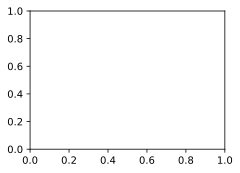

In [56]:
num_epochs = 10
train_ch3(model, trainloader, testloader, loss, num_epochs, optimizer)

#5) Final model accuracy on validation set (5%)